In [37]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [30]:
import pandas as pd
import numpy as np
from os import path
import json
from ast import literal_eval
from public_MAPE import score_function
from time import time
import matplotlib.pyplot as plt
import matplotlib
width=15.0
height=7.5
plt.style.use("bmh")
matplotlib.rcParams['figure.figsize'] = (width, height)
all_colors = [parameter['color'] for parameter in plt.rcParams['axes.prop_cycle']]

In [4]:
data_dir = "data"

train = pd.read_csv(path.join(data_dir, "train_input.csv"), sep=';', index_col=0)
ages = pd.read_csv(path.join(data_dir, "train_output.csv"), sep=';', index_col=0)

In [4]:
id_18 = 479
id_28 = 533
id_38 = 127
id_48 = 217
id_58 = 236
id_68 = 298
idxs = [id_18, id_28, id_38, id_48, id_58, id_68]
ag = ["18", "28", "38", "48", "58", "68"]

In [5]:
samples = train.iloc[idxs, 1:-1].values

NameError: name 'idxs' is not defined

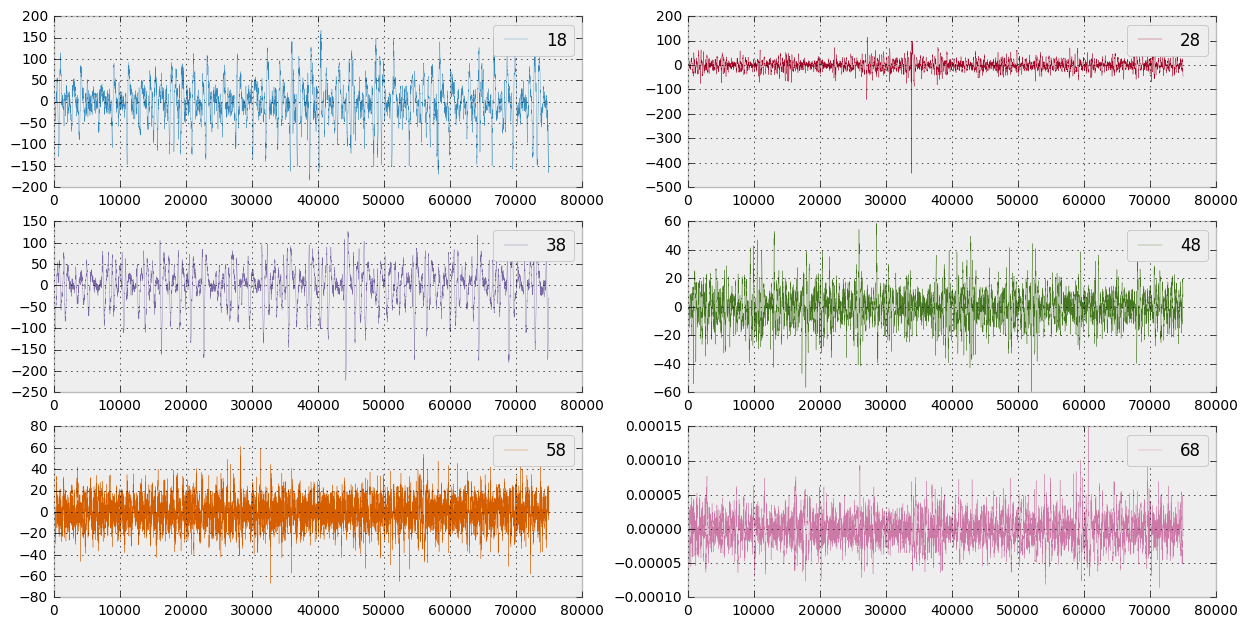

In [6]:
f, axs = plt.subplots(3, 2)
for row in range(3):
    for col in range(2):
        idx = col + 2*row
        axs[row, col].plot(samples[idx, :], linewidth=0.25, color=all_colors[idx], label=ag[idx])
        axs[row, col].legend()
# plt.plot(sample, linewidth=0.5)
#plt.savefig(path.join("figures", "EGG_all_ages.png"), format="png")

In [6]:
from scipy.fftpack import fft
from scipy.signal import blackman
freq = 250
T = 1./freq
N = 75000
middle_N = int(N/2)

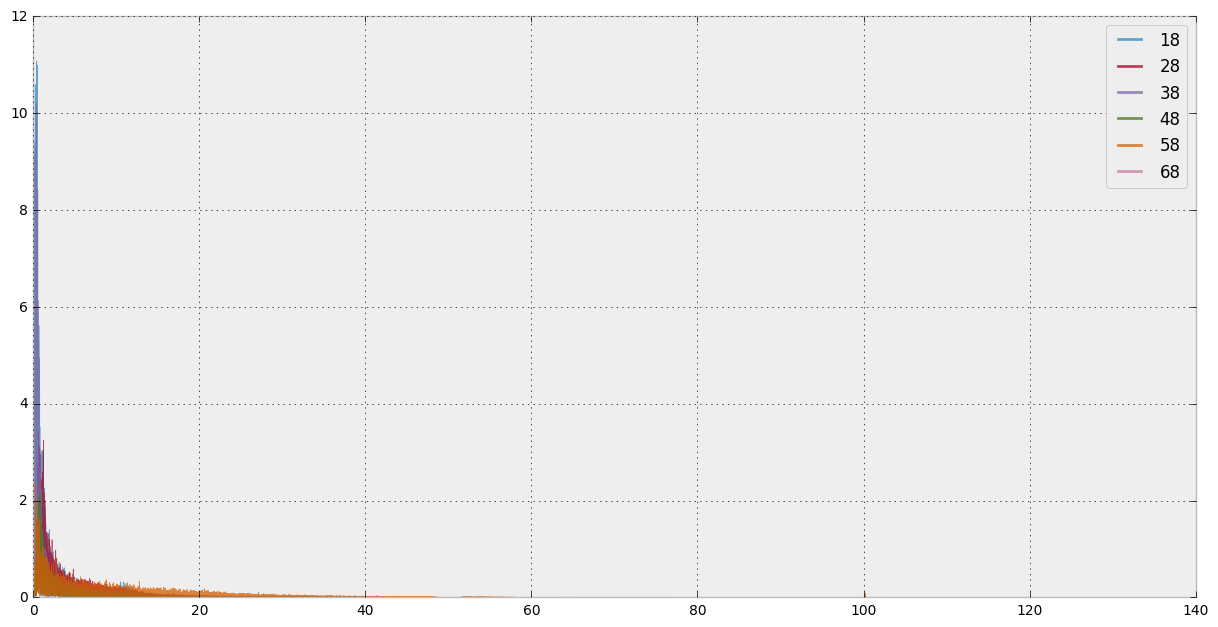

In [21]:
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
for idx in range(6):
    yf = fft(samples[idx, :])
    plt.plot(xf, 2.0/N * np.abs(yf[0:middle_N]), linewidth=0.5, alpha=0.75, color=all_colors[idx], label=ag[idx])
plt.axis("auto")
leg = plt.legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
# plt.savefig(path.join("figures", "FFT_56.png"), format="png")

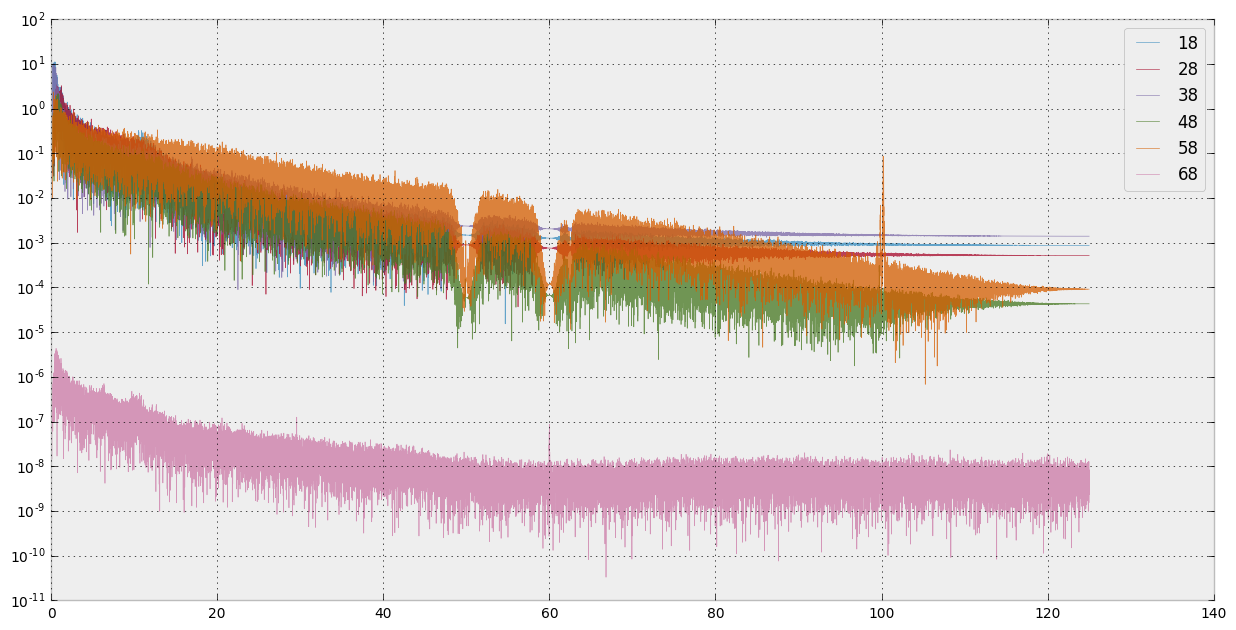

In [14]:
# cut = np.where(xf >= 80)[0][0]
cut = 1
for idx in range(6):
    yf = fft(samples[idx, :])
    plt.semilogy(xf[cut:middle_N], 2.0/N * np.abs(yf[cut:middle_N]), linewidth=0.5, color=all_colors[idx], alpha=0.75, label=ag[idx])
plt.axis("auto")
plt.legend()
#plt.savefig(path.join("figures", "FFT_semilog_all.png"), format="png")

In [7]:
EEG = train.iloc[:, 1:-1]

In [8]:
def get_spectre(row):
    global N
    yf = fft(row)
    ampl = 2.0/N * np.abs(yf)
    return ampl

In [9]:
FFT = EEG.apply(get_spectre, axis=1).iloc[:,:middle_N]

In [54]:
size_bins = 10
FFT["BINS"] = size_bins*((ages - 8) // size_bins) + 8
FFT["BINS"] = FFT["BINS"].replace(68, 68-size_bins)

In [55]:
FFT_mean = FFT.groupby("BINS").mean()

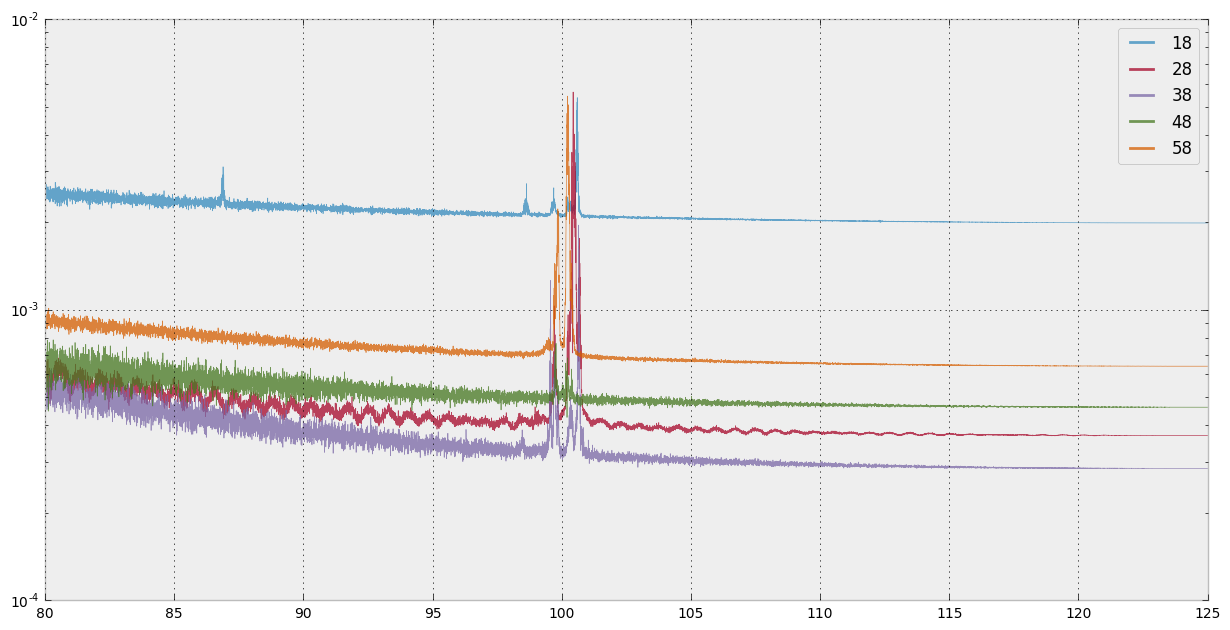

In [12]:
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
cut = np.where(xf >= 80)[0][0]
ags = list(FFT_mean.index)
for idx, age in enumerate(ags):
    ampl = FFT_mean.loc[age,:].values
    plt.semilogy(xf[cut:middle_N], ampl[cut:middle_N], linewidth=0.5, color=all_colors[idx], alpha=0.75, label=age)
plt.axis("auto")
leg = plt.legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
#plt.savefig(path.join("figures", "FFT_semilog_all.png"), format="png")

In [13]:
FFT["BINS"].value_counts()

38    180
18    135
28    120
48     90
58     56
Name: BINS, dtype: int64

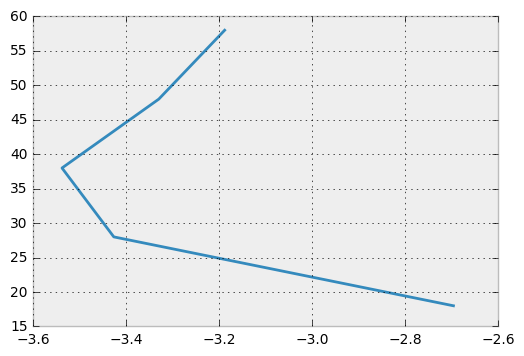

In [61]:
start_freq = 105
begin = int(start_freq*(N/freq))
mean_fft = np.log10(FFT_mean.iloc[:,begin:].mean(axis=1))
plt.plot(mean_fft.values, list(mean_fft.index))

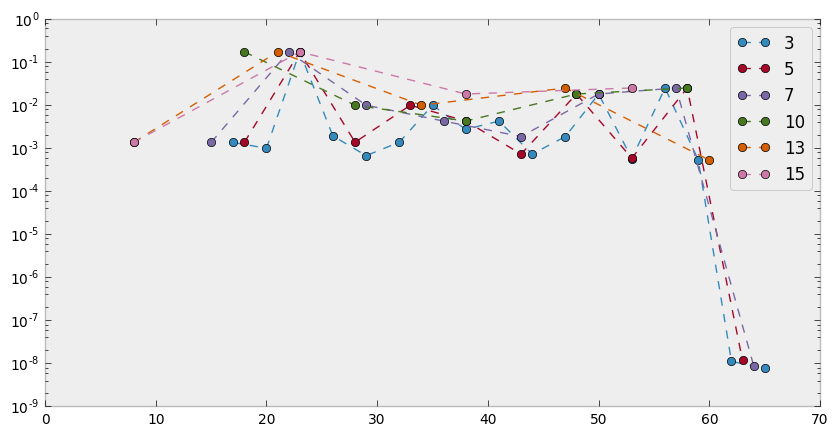

In [44]:
size_bins = [3, 5, 7, 10, 13, 15]
start_freq = 105
begin = int(start_freq*(N/freq))
plt.figure(figsize=(10.0,5.0))
for size_bin in size_bins:
    FFT["BINS"] = size_bin*((ages - 8) // size_bin) + 8
    FFT["BINS"] = FFT["BINS"].replace(68, 68-size_bin)
    FFT_mean = FFT.groupby("BINS").max()
    mean_fft = FFT_mean.iloc[:,begin:].mean(axis=1)
    plt.semilogy(mean_fft, '--o', label=size_bin, linewidth=1)
plt.legend()
ax = plt.gca()
ax.grid(False)

In [67]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [69]:
start_freq = 105
begin = int(start_freq*(N/freq))
mean_fft = FFT.iloc[:,begin:].mean(axis=1)

In [70]:
X = mean_fft.values
y = ages.values
degree = 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [71]:
model = make_pipeline(PolynomialFeatures(degree), Ridge())
model.fit(y_train, X_train)
X_pred = model.predict(y_test)


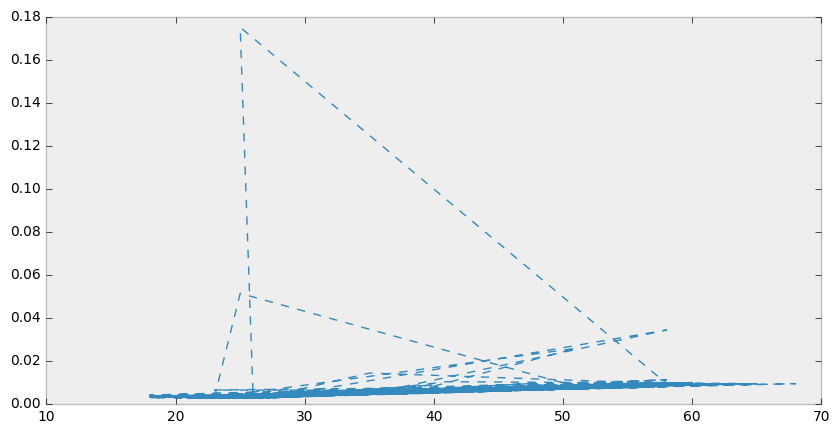

In [78]:
plt.figure(figsize=(10.0,5.0))
plt.plot(ages, mean_fft, '--', linewidth=1)
ax = plt.gca()
ax.grid(False)

In [80]:
mean_fft_age = pd.DataFrame([ages, mean_fft], columns=).set_index('TARGET')

KeyError: 'TARGET'